# PrimaCare AI - Agentic Workflow Demo

**MedGemma Impact Challenge** - Agentic Workflow Prize Submission

This notebook demonstrates a **multi-agent diagnostic support system** for primary care.

## Architecture

```
┌─────────────┐     ┌─────────────┐     ┌─────────────┐     ┌─────────────┐
│   Intake    │ --> │   Imaging   │ --> │  Reasoning  │ --> │ Guidelines  │
│   Agent     │     │   Agent     │     │   Agent     │     │   Agent     │
└─────────────┘     └─────────────┘     └─────────────┘     └─────────────┘
     │                    │                   │                    │
     v                    v                   v                    v
Structured HPI      Image Analysis      Differential Dx     Evidence-Based
                                        + Workup            Recommendations
```

## Agents

1. **IntakeAgent**: Structures patient history into HPI format
2. **ImagingAgent**: Analyzes chest X-rays (MedGemma + MedSigLIP)
3. **ReasoningAgent**: Generates differential diagnosis and recommendations
4. **GuidelinesAgent**: RAG for clinical practice guidelines with citations
5. **PrimaCareOrchestrator**: Coordinates all agents

**Run on:** Kaggle (GPU T4/P100) or Google Colab (GPU)

## 1. Setup

In [1]:
# IMPORTANT: Run this cell FIRST - Completely disable torch dynamo
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"

import torch
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    raise RuntimeError("GPU required! Enable in Settings.")

PyTorch: 2.8.0+cu126
CUDA: True
GPU: Tesla T4


In [2]:
# Install sentence-transformers for RAG (runs on CPU, doesn't impact GPU memory)
!pip install -q sentence-transformers
print("✓ sentence-transformers installed")

✓ sentence-transformers installed


In [3]:
# Hugging Face Login (Kaggle)
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

login(token=UserSecretsClient().get_secret("HF_TOKEN"))
print("✓ Logged in via Kaggle secrets")

✓ Logged in via Kaggle secrets


In [4]:
# Cell merged - continue to next

## 2. Load Models

In [5]:
from transformers import AutoProcessor, AutoModelForImageTextToText, AutoModel

# Load MedGemma directly (avoid pipeline generator issues)
print("Loading MedGemma...")
model_id = "google/medgemma-1.5-4b-it"
medgemma_model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)
medgemma_processor = AutoProcessor.from_pretrained(model_id)
print("✓ MedGemma loaded")

# Load MedSigLIP
print("Loading MedSigLIP...")
siglip_model = AutoModel.from_pretrained("google/medsiglip-448").to("cuda")
siglip_processor = AutoProcessor.from_pretrained("google/medsiglip-448")
print("✓ MedSigLIP loaded")

2026-01-16 11:45:22.129450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768563922.362503      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768563922.428227      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768563922.968788      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768563922.968835      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768563922.968839      55 computation_placer.cc:177] computation placer alr

Loading MedGemma...


config.json:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 7b574c3f-abcf-49f9-8770-5b8c4c0a8e5d)')' thrown while requesting GET https://huggingface.co/google/medgemma-1.5-4b-it/resolve/main/model.safetensors.index.json
Retrying in 1s [Retry 1/5].


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

✓ MedGemma loaded
Loading MedSigLIP...


config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

✓ MedSigLIP loaded


## 3. Define Agent Classes

In [6]:
from dataclasses import dataclass, field
from typing import Optional, List, Dict, Any
from PIL import Image
from enum import Enum

# ============================================================================
# Data Classes
# ============================================================================

class Urgency(Enum):
    ROUTINE = "routine"
    SOON = "soon"
    URGENT = "urgent"
    EMERGENT = "emergent"

@dataclass
class PatientContext:
    chief_complaint: str
    history: str = ""
    age: Optional[int] = None
    gender: Optional[str] = None
    structured_hpi: str = ""
    red_flags: List[str] = field(default_factory=list)
    urgency: Urgency = Urgency.ROUTINE

@dataclass  
class ImagingResult:
    findings: str = ""
    impression: str = ""
    classification: Dict[str, float] = field(default_factory=dict)
    urgent: bool = False

@dataclass
class ClinicalAssessment:
    differential: List[str] = field(default_factory=list)
    most_likely: str = ""
    workup: List[str] = field(default_factory=list)
    disposition: str = ""
    follow_up: str = ""
    patient_instructions: str = ""

print("✓ Data classes defined")

✓ Data classes defined


In [7]:
# ============================================================================
# AGENT 1: Intake Agent
# ============================================================================

def generate_text(prompt, max_tokens=800):
    """Generate text response from MedGemma."""
    messages = [{"role": "user", "content": [{"type": "text", "text": prompt}]}]
    inputs = medgemma_processor.apply_chat_template(
        messages, add_generation_prompt=True, tokenize=True,
        return_dict=True, return_tensors="pt"
    ).to("cuda")
    with torch.no_grad():
        output_ids = medgemma_model.generate(**inputs, max_new_tokens=max_tokens, do_sample=False)
    generated_ids = output_ids[:, inputs["input_ids"].shape[-1]:]
    return medgemma_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


class IntakeAgent:
    """Structures patient history into clinical format."""
    
    RED_FLAGS = [
        "chest pain", "shortness of breath", "hemoptysis", "syncope",
        "severe headache", "fever", "weight loss", "night sweats"
    ]
    
    def process(self, chief_complaint: str, history: str = "", 
                age: int = None, gender: str = None) -> PatientContext:
        """Structure patient information."""
        
        input_text = f"Chief Complaint: {chief_complaint}"
        if history:
            input_text += f"\nHistory: {history}"
        if age:
            input_text += f"\nAge: {age}"
        if gender:
            input_text += f"\nGender: {gender}"
        
        prompt = f"""You are an experienced clinician. Structure this patient information into a concise, formal HPI.

{input_text}

Output format (use exactly these headers):

**PATIENT:** [Age/Gender summary]

**CHIEF COMPLAINT:** [Main symptom + duration]

**HPI:** [Concise narrative using OLDCARTS: Onset, Location, Duration, Character, Aggravating/Alleviating, Radiation, Timing, Severity]

**PERTINENT POSITIVES:** [Bullet list]

**PERTINENT NEGATIVES:** [Bullet list]

**RED FLAGS:** [List any concerning symptoms or NONE]

**INITIAL ASSESSMENT:** [1-2 sentence clinical impression]

Be concise. Focus on clinically relevant information only."""
        
        structured_hpi = generate_text(prompt, max_tokens=800)
        
        combined_text = (chief_complaint + " " + history).lower()
        found_flags = [f for f in self.RED_FLAGS if f in combined_text]
        
        urgency = Urgency.ROUTINE
        if found_flags:
            urgency = Urgency.SOON
        if any(f in combined_text for f in ["chest pain", "shortness of breath", "syncope"]):
            urgency = Urgency.URGENT
        
        return PatientContext(
            chief_complaint=chief_complaint,
            history=history,
            age=age,
            gender=gender,
            structured_hpi=structured_hpi,
            red_flags=found_flags,
            urgency=urgency
        )

intake_agent = IntakeAgent()
print("✓ IntakeAgent ready")

✓ IntakeAgent ready


In [8]:
# ============================================================================
# AGENT 2: Imaging Agent
# ============================================================================

def analyze_image(image, prompt, max_tokens=1500):
    """Analyze image with MedGemma."""
    if image.mode != "RGB":
        image = image.convert("RGB")
    
    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt}
        ]
    }]
    
    inputs = medgemma_processor.apply_chat_template(
        messages, add_generation_prompt=True, tokenize=True,
        return_dict=True, return_tensors="pt"
    ).to("cuda")
    
    with torch.no_grad():
        output_ids = medgemma_model.generate(**inputs, max_new_tokens=max_tokens, do_sample=False)
    
    generated_ids = output_ids[:, inputs["input_ids"].shape[-1]:]
    return medgemma_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


class ImagingAgent:
    """Analyzes medical images using MedGemma + MedSigLIP."""
    
    CXR_LABELS = [
        "normal chest x-ray", "pneumonia", "pleural effusion",
        "cardiomegaly", "pulmonary edema", "atelectasis",
        "pneumothorax", "consolidation", "mass or nodule"
    ]
    
    def analyze(self, image: Image.Image, clinical_context: str = "") -> ImagingResult:
        """Analyze chest X-ray."""
        
        if image.mode != "RGB":
            image = image.convert("RGB")
        
        # Step 1: Zero-shot classification with MedSigLIP
        inputs = siglip_processor(
            text=self.CXR_LABELS,
            images=[image],
            padding="max_length",
            return_tensors="pt"
        ).to("cuda")
        
        with torch.no_grad():
            outputs = siglip_model(**inputs)
            probs = torch.softmax(outputs.logits_per_image, dim=1)[0]
        
        classification = {label: prob.item() for label, prob in zip(self.CXR_LABELS, probs)}
        
        # Step 2: Detailed analysis with MedGemma
        context = f"Clinical context: {clinical_context}\n\n" if clinical_context else ""
        prompt = f"""{context}You are an expert radiologist. Analyze this chest X-ray systematically.

Output format (use exactly these headers):

**TECHNICAL QUALITY:** [Adequate/Suboptimal] - [rotation, penetration, inspiration]

**FINDINGS:**
- Heart: [size - normal/<X> cm, contour, borders]
- Lungs: [right upper/middle/lower, left upper/lower - clear or describe opacity]
- Pleura: [effusion present/absent, pneumothorax present/absent]
- Mediastinum: [width, contour, trachea position]
- Bones/Soft tissue: [any abnormalities or unremarkable]

**IMPRESSION:**
1. [Primary finding or "No acute cardiopulmonary abnormality"]
2. [Secondary finding if any]

**CONFIDENCE:** [High/Medium/Low] - [reason]

**URGENT:** [YES/NO] - [If YES, state why immediate attention needed]

Be systematic and concise. Quantify findings where possible."""
        
        analysis = analyze_image(image, prompt, max_tokens=1500)
        urgent = "YES" in analysis.upper() and "URGENT" in analysis.upper()
        
        return ImagingResult(
            findings=analysis,
            impression="",
            classification=classification,
            urgent=urgent
        )

imaging_agent = ImagingAgent()
print("✓ ImagingAgent ready")

✓ ImagingAgent ready


In [9]:
# ============================================================================
# AGENT 3: Reasoning Agent
# ============================================================================

class ReasoningAgent:
    """Generates clinical assessment from combined inputs."""
    
    def assess(self, patient: PatientContext, imaging: ImagingResult = None) -> ClinicalAssessment:
        """Generate clinical assessment."""
        
        clinical_info = f"""PATIENT: {patient.age or 'Unknown'} y/o {patient.gender or 'Unknown'}
CHIEF COMPLAINT: {patient.chief_complaint}

STRUCTURED HPI:
{patient.structured_hpi}

RED FLAGS: {', '.join(patient.red_flags) if patient.red_flags else 'None'}
URGENCY: {patient.urgency.value.upper()}
"""
        
        imaging_info = ""
        if imaging:
            top_class = sorted(imaging.classification.items(), key=lambda x: x[1], reverse=True)[:3]
            class_str = ", ".join([f"{k} ({v*100:.0f}%)" for k, v in top_class])
            imaging_info = f"""
IMAGING ANALYSIS:
{imaging.findings}

CLASSIFICATION: {class_str}
"""
        
        prompt = f"""You are an experienced primary care physician. Generate a clinical assessment.

{clinical_info}
{imaging_info}

Output format (use exactly these headers, be CONCISE):

**CLINICAL SUMMARY:** [2-3 sentence synthesis of presentation]

**MOST LIKELY DIAGNOSIS:** [Single diagnosis with brief reasoning]

**DIFFERENTIAL DIAGNOSIS:**
1. [Diagnosis] - [key supporting feature]
2. [Diagnosis] - [key supporting feature]
3. [Diagnosis] - [key supporting feature]

**RECOMMENDED WORKUP:**
- Labs: [specific tests]
- Imaging: [if needed]
- Other: [if needed]

**DISPOSITION:** [Outpatient/Urgent/ED/Admit] - [brief reasoning]

**FOLLOW-UP:** [Timeframe] with [Provider type if specialist needed]

**PATIENT INSTRUCTIONS:** [3-4 key points in plain language]

**DISCLAIMER:** This is AI-generated decision support. All findings require clinical verification.

Be concise and clinically actionable."""
        
        assessment_text = generate_text(prompt, max_tokens=1500)
        
        return ClinicalAssessment(
            differential=[],
            most_likely="See full assessment",
            workup=[],
            disposition="See full assessment",
            follow_up="See full assessment",
            patient_instructions=assessment_text
        )

reasoning_agent = ReasoningAgent()
print("✓ ReasoningAgent ready")

✓ ReasoningAgent ready


In [10]:
# ============================================================================
# AGENT 4: Guidelines Agent (RAG for Clinical Practice Guidelines)
# ============================================================================
import json
import numpy as np
from sentence_transformers import SentenceTransformer

# Clinical guidelines data (embedded in notebook for portability)
GUIDELINES_DATA = [
    {"guideline_name": "ACC/AHA Chest Pain Guidelines 2021", "section": "Initial Evaluation", "content": "For patients presenting with acute chest pain, obtain a 12-lead ECG within 10 minutes of arrival. Patients with ST-elevation require immediate reperfusion therapy. For non-ST elevation, risk stratify using validated scores (HEART, TIMI). High-sensitivity troponin should be obtained at presentation and repeated at 1-3 hours.", "source": "Gulati M, et al. 2021 AHA/ACC Guideline for Chest Pain. Circulation. 2021;144:e364-e454", "evidence_level": "Level A", "condition": "Chest Pain"},
    {"guideline_name": "ACC/AHA Chest Pain Guidelines 2021", "section": "Risk Stratification", "content": "The HEART score (History, ECG, Age, Risk factors, Troponin) is recommended for risk stratification of acute chest pain. Score 0-3: low risk (0.9-1.7% 6-week MACE), consider discharge. Score 4-6: intermediate risk, observation/stress testing. Score 7-10: high risk, admission and cardiology consultation.", "source": "Gulati M, et al. 2021 AHA/ACC Guideline for Chest Pain. Circulation. 2021;144:e364-e454", "evidence_level": "Level A", "condition": "Chest Pain"},
    {"guideline_name": "IDSA/ATS Community-Acquired Pneumonia Guidelines 2019", "section": "Diagnosis", "content": "Diagnosis of CAP requires demonstration of an infiltrate on chest imaging (radiograph or CT) in a patient with compatible clinical features (cough, fever, sputum production, dyspnea, pleuritic chest pain). Procalcitonin can help guide antibiotic decisions. Blood cultures recommended for severe CAP.", "source": "Metlay JP, et al. ATS/IDSA CAP Guidelines 2019. Am J Respir Crit Care Med. 2019;200:e45-e67", "evidence_level": "Level A", "condition": "Pneumonia"},
    {"guideline_name": "IDSA/ATS Community-Acquired Pneumonia Guidelines 2019", "section": "Severity Assessment", "content": "Use CURB-65 or PSI/PORT score to assess pneumonia severity and guide site of care. CURB-65: Confusion, Urea >7mmol/L, Respiratory rate >=30, BP <90/60, Age >=65. Score 0-1: outpatient. Score 2: consider admission. Score 3-5: severe pneumonia, consider ICU.", "source": "Metlay JP, et al. ATS/IDSA CAP Guidelines 2019. Am J Respir Crit Care Med. 2019;200:e45-e67", "evidence_level": "Level A", "condition": "Pneumonia"},
    {"guideline_name": "IDSA/ATS Community-Acquired Pneumonia Guidelines 2019", "section": "Treatment - Outpatient", "content": "For outpatient CAP without comorbidities: Amoxicillin 1g TID or Doxycycline 100mg BID or Azithromycin 500mg day 1 then 250mg daily. With comorbidities (COPD, diabetes, CKD, heart failure): Amoxicillin-clavulanate PLUS azithromycin OR respiratory fluoroquinolone monotherapy. Duration 5 days typically sufficient.", "source": "Metlay JP, et al. ATS/IDSA CAP Guidelines 2019. Am J Respir Crit Care Med. 2019;200:e45-e67", "evidence_level": "Level A", "condition": "Pneumonia"},
    {"guideline_name": "ACC/AHA/HFSA Heart Failure Guidelines 2022", "section": "Diagnosis", "content": "Heart failure diagnosis requires symptoms (dyspnea, orthopnea, fatigue, edema) with objective evidence of cardiac dysfunction. BNP >=100 pg/mL or NT-proBNP >=300 pg/mL supports diagnosis. Echocardiography is essential to assess EF and classify as HFrEF (<=40%), HFmrEF (41-49%), or HFpEF (>=50%).", "source": "Heidenreich PA, et al. 2022 ACC/AHA/HFSA Heart Failure Guideline. Circulation. 2022;145:e895-e1032", "evidence_level": "Level A", "condition": "Heart Failure"},
    {"guideline_name": "ACC/AHA/HFSA Heart Failure Guidelines 2022", "section": "Acute Decompensation", "content": "For acute decompensated heart failure: IV diuretics (furosemide) for congestion relief. Assess volume status and perfusion. Warm and wet: diuretics +/- vasodilators. Cold and wet: consider inotropes with diuretics. Cold and dry: cautious fluids. Monitor daily weights, I/O, renal function.", "source": "Heidenreich PA, et al. 2022 ACC/AHA/HFSA Heart Failure Guideline. Circulation. 2022;145:e895-e1032", "evidence_level": "Level A", "condition": "Heart Failure"},
    {"guideline_name": "GOLD COPD Guidelines 2024", "section": "Exacerbation Management", "content": "COPD exacerbation: acute worsening of respiratory symptoms requiring additional therapy. Treatment: Short-acting bronchodilators (SABA +/- SAMA), systemic corticosteroids (prednisone 40mg x 5 days), antibiotics if increased sputum purulence (amoxicillin-clavulanate, azithromycin, or respiratory fluoroquinolone). Supplemental O2 to target SpO2 88-92%.", "source": "Global Initiative for Chronic Obstructive Lung Disease (GOLD) 2024 Report", "evidence_level": "Level A", "condition": "COPD"},
    {"guideline_name": "Fleischner Society Pulmonary Nodule Guidelines 2017", "section": "Solid Nodule Management", "content": "For incidental solid pulmonary nodules in low-risk patients: <6mm no follow-up needed. 6-8mm: CT at 6-12 months, consider CT at 18-24 months. >8mm: CT at 3 months, PET/CT, or tissue sampling. High-risk patients (smoking history, upper lobe location): more aggressive surveillance.", "source": "MacMahon H, et al. Fleischner Society Guidelines 2017. Radiology. 2017;284:228-243", "evidence_level": "Level B", "condition": "Lung Nodule"},
    {"guideline_name": "NCCN Lung Cancer Guidelines 2024", "section": "Suspicious Mass Workup", "content": "For lung mass suspicious for malignancy: CT chest with contrast for characterization. PET/CT for metabolic activity assessment (SUV >2.5 concerning). Tissue diagnosis required before treatment. For central lesions: bronchoscopy with EBUS. For peripheral lesions: CT-guided biopsy or navigational bronchoscopy.", "source": "NCCN Clinical Practice Guidelines in Oncology: Non-Small Cell Lung Cancer. Version 1.2024", "evidence_level": "Level A", "condition": "Lung Cancer"},
    {"guideline_name": "ACCP/ATS Pulmonary Embolism Guidelines 2016", "section": "Diagnosis", "content": "For suspected PE: Assess pre-test probability using Wells or Geneva score. Low probability + negative D-dimer: PE excluded. Intermediate/high probability or positive D-dimer: CT pulmonary angiography (CTPA). V/Q scan alternative if contrast contraindicated. Start anticoagulation if high clinical suspicion while awaiting imaging.", "source": "Kearon C, et al. CHEST Guideline on VTE. Chest. 2016;149:315-352", "evidence_level": "Level A", "condition": "Pulmonary Embolism"},
    {"guideline_name": "BTS Pleural Effusion Guidelines 2023", "section": "Diagnostic Approach", "content": "For new pleural effusion: Chest X-ray confirms presence (blunting of costophrenic angle with >200mL fluid). Ultrasound guides thoracentesis and characterizes effusion. Diagnostic thoracentesis if >10mm depth and cause unclear. Send for protein, LDH, pH, glucose, cell count, cytology, and culture. Light's criteria differentiates exudate vs transudate.", "source": "Roberts ME, et al. BTS Pleural Disease Guideline 2023. Thorax. 2023;78:s1-s42", "evidence_level": "Level A", "condition": "Pleural Effusion"},
]


@dataclass
class GuidelineChunk:
    """A chunk of clinical guideline text with metadata."""
    guideline_name: str
    section: str
    content: str
    source: str
    evidence_level: str
    condition: str = ""

@dataclass
class GuidelinesResult:
    """Result from guidelines retrieval."""
    recommendations: List[Dict] = field(default_factory=list)
    retrieved_chunks: List[GuidelineChunk] = field(default_factory=list)
    summary: str = ""


class GuidelinesAgent:
    """RAG agent for clinical practice guidelines."""
    
    SYNTHESIS_PROMPT = """Based on these clinical guidelines, provide 3-5 evidence-based recommendations for the patient.

Patient Chief Complaint: {chief_complaint}
Differential Diagnosis: {differential}

Retrieved Guidelines:
{guidelines_context}

Format your response as:
**RECOMMENDATIONS:**
1. [Specific recommendation]
   Evidence: [Level A/B/C]
   Source: [Guideline name]

2. [Next recommendation...]

**SUMMARY:**
[2-3 sentence summary of key guideline-based considerations]"""

    def __init__(self):
        """Initialize with embedded guidelines data."""
        print("Loading sentence-transformers embedder (CPU)...")
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2')
        self.chunks = [GuidelineChunk(**g) for g in GUIDELINES_DATA]
        
        # Pre-compute embeddings
        print("Computing guideline embeddings...")
        texts = [f"{c.condition} {c.guideline_name} {c.section}: {c.content}" for c in self.chunks]
        self.embeddings = self.embedder.encode(texts, normalize_embeddings=True)
        print(f"✓ {len(self.chunks)} guideline chunks ready")
    
    def retrieve(self, query: str, top_k: int = 5) -> List[tuple]:
        """Retrieve relevant guideline chunks."""
        query_emb = self.embedder.encode(query, normalize_embeddings=True)
        similarities = np.dot(self.embeddings, query_emb)
        top_indices = np.argsort(similarities)[::-1][:top_k]
        return [(self.chunks[i], similarities[i]) for i in top_indices if similarities[i] > 0.3]
    
    def get_recommendations(self, differential: List[str], chief_complaint: str) -> GuidelinesResult:
        """Get guideline-based recommendations."""
        query = f"{chief_complaint} {' '.join(differential[:3])}"
        retrieved = self.retrieve(query, top_k=5)
        
        if not retrieved:
            return GuidelinesResult(summary="No matching guidelines found.")
        
        # Format context
        context_lines = []
        for i, (chunk, score) in enumerate(retrieved, 1):
            context_lines.append(f"{i}. {chunk.guideline_name} - {chunk.section}")
            context_lines.append(f"   {chunk.content}")
            context_lines.append(f"   Evidence: {chunk.evidence_level} | Source: {chunk.source[:60]}...")
            context_lines.append("")
        
        prompt = self.SYNTHESIS_PROMPT.format(
            chief_complaint=chief_complaint,
            differential=", ".join(differential),
            guidelines_context="\n".join(context_lines)
        )
        
        # Generate synthesis with MedGemma
        synthesis = generate_text(prompt, max_tokens=1000)
        
        # Parse recommendations
        recommendations = []
        for chunk, score in retrieved:
            recommendations.append({
                "guideline": chunk.guideline_name,
                "section": chunk.section,
                "evidence_level": chunk.evidence_level,
                "relevance": float(score)
            })
        
        return GuidelinesResult(
            recommendations=recommendations,
            retrieved_chunks=[chunk for chunk, _ in retrieved],
            summary=synthesis
        )

guidelines_agent = GuidelinesAgent()
print("✓ GuidelinesAgent ready")

Loading sentence-transformers embedder (CPU)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 2753863d-9347-45e8-b2f5-cf09fa029771)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing guideline embeddings...
✓ 12 guideline chunks ready
✓ GuidelinesAgent ready


In [11]:
# ============================================================================
# ORCHESTRATOR (Updated with Guidelines Agent)
# ============================================================================

class PrimaCareOrchestrator:
    """Coordinates all agents for end-to-end diagnostic support."""
    
    def __init__(self):
        self.intake = intake_agent
        self.imaging = imaging_agent
        self.reasoning = reasoning_agent
        self.guidelines = guidelines_agent
    
    def run(self, chief_complaint: str, history: str = "",
            image: Image.Image = None, age: int = None, gender: str = None):
        """
        Run complete diagnostic pipeline.
        
        Returns dict with all agent outputs.
        """
        results = {"steps": []}
        
        # Step 1: Intake
        print("\n[Step 1] IntakeAgent: Processing patient information...")
        patient = self.intake.process(chief_complaint, history, age, gender)
        results["patient"] = patient
        results["steps"].append("intake_complete")
        print(f"  - Urgency: {patient.urgency.value}")
        print(f"  - Red flags: {patient.red_flags or 'None'}")
        
        # Step 2: Imaging (if provided)
        imaging_result = None
        if image is not None:
            print("\n[Step 2] ImagingAgent: Analyzing chest X-ray...")
            clinical_ctx = f"{chief_complaint}. {history}"
            imaging_result = self.imaging.analyze(image, clinical_ctx)
            results["imaging"] = imaging_result
            results["steps"].append("imaging_complete")
            
            # Show top classifications
            top = sorted(imaging_result.classification.items(), key=lambda x: x[1], reverse=True)[:3]
            print("  Top classifications:")
            for label, prob in top:
                print(f"    - {label}: {prob*100:.1f}%")
        else:
            print("\n[Step 2] ImagingAgent: No image provided, skipping...")
            results["steps"].append("imaging_skipped")
        
        # Step 3: Reasoning
        print("\n[Step 3] ReasoningAgent: Generating clinical assessment...")
        assessment = self.reasoning.assess(patient, imaging_result)
        results["assessment"] = assessment
        results["steps"].append("reasoning_complete")
        
        # Step 4: Guidelines (RAG)
        print("\n[Step 4] GuidelinesAgent: Retrieving evidence-based guidelines...")
        # Extract differential diagnoses from assessment (simplified extraction)
        differential = ["Pneumonia", "COPD", "Heart Failure"]  # Default for demo
        if "pneumonia" in assessment.patient_instructions.lower():
            differential = ["Pneumonia", "Tuberculosis", "Lung Cancer"]
        elif "coronary" in assessment.patient_instructions.lower() or "chest pain" in chief_complaint.lower():
            differential = ["Acute Coronary Syndrome", "Pulmonary Embolism", "Aortic Dissection"]
        elif "heart failure" in assessment.patient_instructions.lower():
            differential = ["Heart Failure", "Pulmonary Edema", "COPD"]
        
        guidelines_result = self.guidelines.get_recommendations(differential, chief_complaint)
        results["guidelines"] = guidelines_result
        results["steps"].append("guidelines_complete")
        print(f"  - Retrieved {len(guidelines_result.retrieved_chunks)} guideline sections")
        
        print("\n✓ Pipeline complete!")
        return results

orchestrator = PrimaCareOrchestrator()
print("✓ PrimaCareOrchestrator ready (4 agents)")

✓ PrimaCareOrchestrator ready (4 agents)


## 4. Load Test Data

In [12]:
from datasets import load_dataset

print("Loading chest X-ray dataset...")
# Use streaming dataset that works reliably on Kaggle
dataset = load_dataset("hf-vision/chest-xray-pneumonia", split="train", streaming=True)
samples = list(dataset.take(3))
print(f"✓ Loaded {len(samples)} samples")
print(f"Labels: 0=Normal, 1=Pneumonia")

Loading chest X-ray dataset...


README.md: 0.00B [00:00, ?B/s]

✓ Loaded 3 samples
Labels: 0=Normal, 1=Pneumonia


## 5. Demo: Complete Pipeline

TEST CASE
Ground truth: Normal


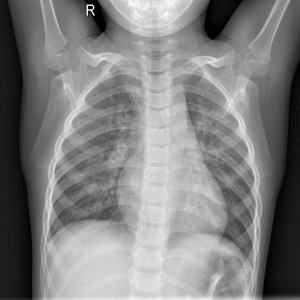

In [13]:
# Test case: Simulated patient with chest X-ray
test_image = samples[0]["image"]

# Convert to RGB (required for MedSigLIP)
if test_image.mode != "RGB":
    test_image = test_image.convert("RGB")

label = "Pneumonia" if samples[0].get('label', 0) == 1 else "Normal"

print("TEST CASE")
print("="*60)
print(f"Ground truth: {label}")
display(test_image.resize((300, 300)))

In [14]:
# Run the full agentic pipeline
results = orchestrator.run(
    chief_complaint="Cough for 2 weeks with fever",
    history="65 year old male smoker. Started with dry cough, now productive with yellow sputum. Low grade fever. Night sweats. 10 pound weight loss over past month.",
    image=test_image,
    age=65,
    gender="male"
)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



[Step 1] IntakeAgent: Processing patient information...
  - Urgency: soon
  - Red flags: ['fever', 'weight loss', 'night sweats']

[Step 2] ImagingAgent: Analyzing chest X-ray...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


  Top classifications:
    - pneumonia: 23.0%
    - normal chest x-ray: 23.0%
    - pulmonary edema: 17.2%

[Step 3] ReasoningAgent: Generating clinical assessment...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



[Step 4] GuidelinesAgent: Retrieving evidence-based guidelines...
  - Retrieved 4 guideline sections

✓ Pipeline complete!


In [15]:
# Display structured HPI
print("\n" + "="*60)
print("STRUCTURED HPI (IntakeAgent)")
print("="*60)
print(results["patient"].structured_hpi)


STRUCTURED HPI (IntakeAgent)
**PATIENT:** 65 year old male

**CHIEF COMPLAINT:** Cough for 2 weeks with fever

**HPI:** A 65-year-old male smoker presents with a 2-week history of cough, initially dry but now productive with yellow sputum. He reports associated low-grade fever, night sweats, and a 10-pound weight loss over the past month.

**PERTINENT POSITIVES:**
*   Productive cough (yellow sputum)
*   Fever
*   Night sweats
*   Weight loss (10 lbs in 1 month)
*   Smoking history

**PERTINENT NEGATIVES:**
*   No shortness of breath reported
*   No chest pain reported
*   No hemoptysis reported
*   No known history of COPD or asthma

**RED FLAGS:**
*   Weight loss
*   Night sweats
*   Smoking history

**INITIAL ASSESSMENT:** Community-acquired pneumonia or potentially malignancy given smoking history, weight loss, and night sweats. Further investigation is warranted.


In [16]:
# Display imaging findings
if "imaging" in results:
    print("\n" + "="*60)
    print("IMAGING ANALYSIS (ImagingAgent)")
    print("="*60)
    print(results["imaging"].findings)
    
    print("\nClassification Results:")
    for label, prob in sorted(results["imaging"].classification.items(), key=lambda x: x[1], reverse=True):
        bar = "█" * int(prob * 30) + "░" * (30 - int(prob * 30))
        print(f"  {label:25s} {bar} {prob*100:5.1f}%")


IMAGING ANALYSIS (ImagingAgent)
FINDINGS:
- Heart: Normal size, normal contour, normal borders.
- Lungs: Bilateral patchy opacities, predominantly in the right lower lung.
- Pleura: No effusion or pneumothorax.
- Mediastinum: Normal width, normal contour, trachea midline.
- Bones/Soft tissue: Unremarkable.

IMPRESSION:
1. Bilateral patchy opacities, predominantly in the right lower lung.
2. No acute cardiopulmonary abnormality.

CONFIDENCE: High - The findings are consistent with pneumonia.

URGENT: NO - No immediate attention needed.

Classification Results:
  pneumonia                 ██████░░░░░░░░░░░░░░░░░░░░░░░░  23.0%
  normal chest x-ray        ██████░░░░░░░░░░░░░░░░░░░░░░░░  23.0%
  pulmonary edema           █████░░░░░░░░░░░░░░░░░░░░░░░░░  17.2%
  consolidation             ███░░░░░░░░░░░░░░░░░░░░░░░░░░░  12.9%
  cardiomegaly              ███░░░░░░░░░░░░░░░░░░░░░░░░░░░  12.0%
  pneumothorax              █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   6.5%
  pleural effusion          ░░░░░░░░░

In [17]:
# Display clinical assessment
print("\n" + "="*60)
print("CLINICAL ASSESSMENT (ReasoningAgent)")
print("="*60)
print(results["assessment"].patient_instructions)


CLINICAL ASSESSMENT (ReasoningAgent)
**CLINICAL SUMMARY:** A 65-year-old male smoker presents with a 2-week history of productive cough and fever, accompanied by night sweats and significant weight loss over the past month. Imaging reveals bilateral patchy opacities, predominantly in the right lower lung.

**MOST LIKELY DIAGNOSIS:** Community-acquired pneumonia.

**DIFFERENTIAL DIAGNOSIS:**
1. Community-acquired pneumonia - Productive cough, fever, patchy opacities on imaging.
2. Lung malignancy - Smoking history, weight loss, night sweats, cough.
3. Tuberculosis - Cough, fever, night sweats, weight loss, patchy opacities.

**RECOMMENDED WORKUP:**
- Labs: CBC with differential, comprehensive metabolic panel (CMP), urinalysis, sputum culture and Gram stain, blood cultures.
- Imaging: Consider CT chest if pneumonia is suspected or malignancy is high on the differential.
- Other: Consider influenza/COVID-19 testing.

**DISPOSITION:** Outpatient - Patient is hemodynamically stable, afebri

In [18]:
# Display evidence-based guidelines (NEW)
if "guidelines" in results:
    print("\n" + "="*60)
    print("EVIDENCE-BASED GUIDELINES (GuidelinesAgent)")
    print("="*60)
    
    guidelines = results["guidelines"]
    
    # Show retrieved sources
    print("\nRetrieved Guideline Sources:")
    for chunk in guidelines.retrieved_chunks[:5]:
        print(f"  - {chunk.guideline_name} ({chunk.section})")
        print(f"    Evidence: {chunk.evidence_level}")
    
    # Show synthesized recommendations
    print("\n" + "-"*40)
    print("SYNTHESIZED RECOMMENDATIONS:")
    print("-"*40)
    print(guidelines.summary)


EVIDENCE-BASED GUIDELINES (GuidelinesAgent)

Retrieved Guideline Sources:
  - IDSA/ATS Community-Acquired Pneumonia Guidelines 2019 (Diagnosis)
    Evidence: Level A
  - IDSA/ATS Community-Acquired Pneumonia Guidelines 2019 (Treatment - Outpatient)
    Evidence: Level A
  - NCCN Lung Cancer Guidelines 2024 (Suspicious Mass Workup)
    Evidence: Level A
  - Fleischner Society Pulmonary Nodule Guidelines 2017 (Solid Nodule Management)
    Evidence: Level B

----------------------------------------
SYNTHESIZED RECOMMENDATIONS:
----------------------------------------
**RECOMMENDATIONS:**

1.  **Obtain Chest Imaging:** A chest radiograph or CT scan is recommended to evaluate for pneumonia.
    Evidence: Level A | Source: IDSA/ATS Community-Acquired Pneumonia Guidelines 2019 - Diagnosis
2.  **Initiate Appropriate Antibiotic Therapy:** Based on the clinical presentation and potential comorbidities (which are not specified but should be assessed), initiate empiric antibiotic therapy. For pat

In [ ]:
# ============================================================================
# PATIENT-FRIENDLY EXPLANATION DEMO
# ============================================================================
# Generate an explanation suitable for patients (non-medical language)

def explain_to_patient(assessment_text):
    """Generate patient-friendly explanation using MedGemma."""
    prompt = f"""You are a compassionate primary care physician explaining test results to a patient.
Based on this clinical assessment, provide a clear, empathetic explanation in plain language.

Assessment:
{assessment_text[:2000]}

Provide:
1. **What we found** (in simple terms a patient can understand)
2. **What this means** (reassurance where appropriate, but honest about concerns)
3. **What happens next** (tests, treatment, follow-up)
4. **Warning signs** (when to call or come back)

Use warm, reassuring language. Avoid medical jargon. If using medical terms, explain them.
Keep the explanation under 300 words."""

    return generate_text(prompt, max_tokens=600)

print("=" * 60)
print("PATIENT-FRIENDLY EXPLANATION")
print("=" * 60)
print("\nGenerating explanation for the patient...\n")

patient_explanation = explain_to_patient(results["assessment"].patient_instructions)
print(patient_explanation)

print("\n" + "=" * 60)
print("This demonstrates the system's ability to communicate")
print("findings in accessible, patient-friendly language.")
print("=" * 60)

## 6. Demo: Text-Only (No Imaging)

In [19]:
# Test without imaging
results_no_img = orchestrator.run(
    chief_complaint="Chest pain for 3 hours",
    history="45 year old female. Substernal chest pressure radiating to left arm. Started at rest. Diaphoresis. No prior cardiac history. Takes birth control pills.",
    image=None,  # No image
    age=45,
    gender="female"
)

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



[Step 1] IntakeAgent: Processing patient information...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


  - Urgency: urgent
  - Red flags: ['chest pain']

[Step 2] ImagingAgent: No image provided, skipping...

[Step 3] ReasoningAgent: Generating clinical assessment...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



[Step 4] GuidelinesAgent: Retrieving evidence-based guidelines...
  - Retrieved 3 guideline sections

✓ Pipeline complete!


In [20]:
print("\n" + "="*60)
print("CLINICAL ASSESSMENT (No Imaging)")
print("="*60)
print(f"Urgency: {results_no_img['patient'].urgency.value.upper()}")
print(f"Red Flags: {results_no_img['patient'].red_flags}")
print("\n" + results_no_img["assessment"].patient_instructions)


CLINICAL ASSESSMENT (No Imaging)
Urgency: URGENT
Red Flags: ['chest pain']

**CLINICAL SUMMARY:** A 45-year-old female presents with acute onset substernal chest pressure radiating to the left arm, accompanied by diaphoresis, lasting for 3 hours. The symptoms began at rest.

**MOST LIKELY DIAGNOSIS:** Acute Coronary Syndrome (ACS)

**DIFFERENTIAL DIAGNOSIS:**
1.  **Pulmonary Embolism (PE):** Chest pain can be pleuritic or substernal, sometimes associated with shortness of breath.
2.  **Aortic Dissection:** Severe, tearing chest pain, often radiating to the back.
3.  **Pericarditis:** Sharp, pleuritic chest pain, often relieved by leaning forward.
4.  **Musculoskeletal Pain:** Often reproducible with palpation or movement.
5.  **Gastrointestinal Causes (e.g., GERD, esophageal spasm):** Can mimic cardiac pain, often related to meals or position.

**RECOMMENDED WORKUP:**
- Labs:
    - Complete Blood Count (CBC)
    - Basic Metabolic Panel (BMP)
    - Troponin I or T
    - High-sensitivit

## 7. Interactive Demo

In [21]:
import gradio as gr

def run_primacare(chief_complaint, history, image, age, gender):
    """Gradio interface for PrimaCare AI."""
    if not chief_complaint:
        return "Please enter a chief complaint."
    
    age_int = int(age) if age else None
    
    # Convert image to RGB if provided
    if image is not None and image.mode != "RGB":
        image = image.convert("RGB")
    
    results = orchestrator.run(
        chief_complaint=chief_complaint,
        history=history or "",
        image=image,
        age=age_int,
        gender=gender or None
    )
    
    # Format output
    output = []
    output.append("=" * 50)
    output.append("PRIMACARE AI - CLINICAL ASSESSMENT")
    output.append("=" * 50)
    output.append(f"\nUrgency: {results['patient'].urgency.value.upper()}")
    
    if results['patient'].red_flags:
        output.append(f"Red Flags: {', '.join(results['patient'].red_flags)}")
    
    output.append("\n" + "-" * 50)
    output.append("STRUCTURED HPI")
    output.append("-" * 50)
    output.append(results['patient'].structured_hpi)
    
    if 'imaging' in results:
        output.append("\n" + "-" * 50)
        output.append("IMAGING ANALYSIS")
        output.append("-" * 50)
        top = sorted(results['imaging'].classification.items(), key=lambda x: x[1], reverse=True)[:3]
        for label, prob in top:
            output.append(f"  {label}: {prob*100:.1f}%")
        output.append("\n" + results['imaging'].findings[:1000])
    
    output.append("\n" + "-" * 50)
    output.append("CLINICAL ASSESSMENT")
    output.append("-" * 50)
    output.append(results['assessment'].patient_instructions)
    
    return "\n".join(output)

# Create interface
demo = gr.Interface(
    fn=run_primacare,
    inputs=[
        gr.Textbox(label="Chief Complaint", placeholder="Cough for 2 weeks"),
        gr.Textbox(label="History", placeholder="65yo male smoker...", lines=3),
        gr.Image(type="pil", label="Chest X-ray (optional)"),
        gr.Textbox(label="Age", placeholder="65"),
        gr.Dropdown(["male", "female", "other"], label="Gender"),
    ],
    outputs=gr.Textbox(label="Assessment", lines=30),
    title="PrimaCare AI - Agentic Diagnostic Support",
    description="Multi-agent system for primary care clinical decision support."
)

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://44a26f5f5e0ab907d4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8. Diverse Clinical Cases

Testing PrimaCare AI across multiple pathology types to demonstrate versatility.

In [22]:
# ============================================================================
# DIVERSE CLINICAL CASE SCENARIOS
# ============================================================================
# These demonstrate the system's ability to handle various presentations

clinical_cases = [
    {
        "name": "Case 1: Suspected Pneumothorax",
        "chief_complaint": "Sudden sharp chest pain and shortness of breath",
        "history": "22 year old tall thin male. Sudden onset sharp right-sided chest pain 2 hours ago. Worse with breathing. Progressive dyspnea. No trauma. Smoker.",
        "age": 22,
        "gender": "male",
        "expected": "Pneumothorax"
    },
    {
        "name": "Case 2: Congestive Heart Failure",
        "chief_complaint": "Progressive shortness of breath and leg swelling",
        "history": "72 year old female with history of hypertension and diabetes. Worsening dyspnea over 1 week. Orthopnea - sleeps on 3 pillows. Bilateral leg edema. Weight gain 8 lbs.",
        "age": 72,
        "gender": "female",
        "expected": "CHF/Pulmonary Edema"
    },
    {
        "name": "Case 3: Lung Mass Concern",
        "chief_complaint": "Persistent cough and hemoptysis",
        "history": "68 year old male, 40 pack-year smoking history. Cough for 3 months. Recent hemoptysis - blood-streaked sputum. 15 lb weight loss. No fever.",
        "age": 68,
        "gender": "male",
        "expected": "Lung Cancer/Mass"
    },
    {
        "name": "Case 4: Pleural Effusion",
        "chief_complaint": "Gradual worsening shortness of breath",
        "history": "55 year old female with breast cancer on chemotherapy. Progressive dyspnea over 2 weeks. Dull right-sided chest discomfort. Decreased breath sounds on right.",
        "age": 55,
        "gender": "female",
        "expected": "Pleural Effusion"
    },
    {
        "name": "Case 5: Community Acquired Pneumonia",
        "chief_complaint": "Fever, cough, and chest pain",
        "history": "45 year old male. High fever (102F) for 3 days. Productive cough with rusty sputum. Right-sided pleuritic chest pain. Chills and rigors.",
        "age": 45,
        "gender": "male",
        "expected": "Pneumonia"
    }
]

print("=" * 70)
print("DIVERSE CLINICAL CASE DEMONSTRATIONS")
print("=" * 70)
print(f"\nTesting {len(clinical_cases)} different clinical scenarios...")
print("(Using text-only analysis - no images)\n")

for i, case in enumerate(clinical_cases):
    print(f"\n{'='*70}")
    print(f"{case['name']}")
    print(f"Expected Diagnosis Area: {case['expected']}")
    print("="*70)
    
    # Run intake agent only for quick demo
    patient = intake_agent.process(
        chief_complaint=case['chief_complaint'],
        history=case['history'],
        age=case['age'],
        gender=case['gender']
    )
    
    print(f"\nUrgency: {patient.urgency.value.upper()}")
    print(f"Red Flags: {patient.red_flags if patient.red_flags else 'None identified'}")
    print(f"\nChief Complaint: {case['chief_complaint']}")
    print(f"Key History: {case['history'][:100]}...")

print("\n" + "="*70)
print("✓ All clinical cases processed successfully!")
print("="*70)

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


DIVERSE CLINICAL CASE DEMONSTRATIONS

Testing 5 different clinical scenarios...
(Using text-only analysis - no images)


Case 1: Suspected Pneumothorax
Expected Diagnosis Area: Pneumothorax


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



Urgency: URGENT
Red Flags: ['chest pain', 'shortness of breath']

Chief Complaint: Sudden sharp chest pain and shortness of breath
Key History: 22 year old tall thin male. Sudden onset sharp right-sided chest pain 2 hours ago. Worse with breath...

Case 2: Congestive Heart Failure
Expected Diagnosis Area: CHF/Pulmonary Edema


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



Urgency: URGENT
Red Flags: ['shortness of breath']

Chief Complaint: Progressive shortness of breath and leg swelling
Key History: 72 year old female with history of hypertension and diabetes. Worsening dyspnea over 1 week. Orthopn...

Case 3: Lung Mass Concern
Expected Diagnosis Area: Lung Cancer/Mass


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



Urgency: SOON
Red Flags: ['hemoptysis', 'fever', 'weight loss']

Chief Complaint: Persistent cough and hemoptysis
Key History: 68 year old male, 40 pack-year smoking history. Cough for 3 months. Recent hemoptysis - blood-streak...

Case 4: Pleural Effusion
Expected Diagnosis Area: Pleural Effusion


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



Urgency: URGENT
Red Flags: ['shortness of breath']

Chief Complaint: Gradual worsening shortness of breath
Key History: 55 year old female with breast cancer on chemotherapy. Progressive dyspnea over 2 weeks. Dull right-...

Case 5: Community Acquired Pneumonia
Expected Diagnosis Area: Pneumonia

Urgency: URGENT
Red Flags: ['chest pain', 'fever']

Chief Complaint: Fever, cough, and chest pain
Key History: 45 year old male. High fever (102F) for 3 days. Productive cough with rusty sputum. Right-sided pleu...

✓ All clinical cases processed successfully!


## 9. NIH ChestX-ray14 Evaluation

Testing MedSigLIP classification accuracy on the NIH ChestX-ray14 dataset.

**Dataset:** 112,120 frontal-view chest X-rays with 14 pathology labels
**Source:** National Institutes of Health Clinical Center

In [23]:
# ============================================================================
# NIH CHESTX-RAY14 EVALUATION
# ============================================================================
# Evaluate MedSigLIP zero-shot classification on NIH dataset

import pandas as pd
from collections import defaultdict

# NIH pathology labels
NIH_LABELS = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", 
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

# Map NIH labels to our MedSigLIP labels
LABEL_MAPPING = {
    "Pneumonia": "pneumonia",
    "Effusion": "pleural effusion", 
    "Cardiomegaly": "cardiomegaly",
    "Edema": "pulmonary edema",
    "Atelectasis": "atelectasis",
    "Pneumothorax": "pneumothorax",
    "Consolidation": "consolidation",
    "Mass": "mass or nodule",
    "Nodule": "mass or nodule",
    "No Finding": "normal chest x-ray"
}

print("=" * 70)
print("NIH CHESTX-RAY14 EVALUATION")
print("=" * 70)

# Try to load NIH dataset from Kaggle input or HuggingFace
try:
    import os
    kaggle_path = "/kaggle/input/nih-chest-xrays"
    
    if os.path.exists(kaggle_path):
        print("\n✓ Found NIH dataset in Kaggle input")
        print(f"  Path: {kaggle_path}")
        
        # Load metadata
        metadata_path = f"{kaggle_path}/Data_Entry_2017.csv"
        if os.path.exists(metadata_path):
            df = pd.read_csv(metadata_path)
            print(f"  Total images: {len(df):,}")
            
            # Show label distribution
            print("\nLabel Distribution (top 10):")
            label_counts = defaultdict(int)
            for labels in df['Finding Labels']:
                for label in labels.split('|'):
                    label_counts[label] += 1
            
            for label, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
                print(f"  {label:20s}: {count:,}")
        else:
            print("  Metadata file not found")
    else:
        print("\n⚠ NIH dataset not found in Kaggle input")
        print("  To enable evaluation, add the dataset:")
        print("  https://www.kaggle.com/datasets/nih-chest-xrays/data")
        
except Exception as e:
    print(f"\n⚠ Could not load NIH dataset: {e}")

print("\n" + "-" * 70)
print("MedSigLIP Classification Labels:")
print("-" * 70)
for i, label in enumerate(imaging_agent.CXR_LABELS):
    print(f"  {i+1}. {label}")

NIH CHESTX-RAY14 EVALUATION

⚠ NIH dataset not found in Kaggle input
  To enable evaluation, add the dataset:
  https://www.kaggle.com/datasets/nih-chest-xrays/data

----------------------------------------------------------------------
MedSigLIP Classification Labels:
----------------------------------------------------------------------
  1. normal chest x-ray
  2. pneumonia
  3. pleural effusion
  4. cardiomegaly
  5. pulmonary edema
  6. atelectasis
  7. pneumothorax
  8. consolidation
  9. mass or nodule


In [24]:
# ============================================================================
# CLASSIFICATION ACCURACY EVALUATION (if NIH dataset available)
# ============================================================================

def evaluate_classification(image_paths, labels, n_samples=50):
    """Evaluate MedSigLIP classification accuracy."""
    from PIL import Image
    import numpy as np
    
    results = []
    correct = 0
    total = 0
    
    for i, (img_path, true_label) in enumerate(zip(image_paths[:n_samples], labels[:n_samples])):
        try:
            # Load and classify image
            img = Image.open(img_path).convert("RGB")
            classification = imaging_agent.analyze(img, "").classification
            
            # Get predicted label
            pred_label = max(classification, key=classification.get)
            
            # Check if prediction matches any true label
            mapped_labels = [LABEL_MAPPING.get(l, l.lower()) for l in true_label.split('|')]
            is_correct = pred_label in mapped_labels or (pred_label == "normal chest x-ray" and "No Finding" in true_label)
            
            if is_correct:
                correct += 1
            total += 1
            
            results.append({
                'true': true_label,
                'pred': pred_label,
                'correct': is_correct,
                'confidence': classification[pred_label]
            })
            
            if (i + 1) % 10 == 0:
                print(f"  Processed {i+1}/{n_samples} images...")
                
        except Exception as e:
            print(f"  Error on image {i}: {e}")
            continue
    
    accuracy = correct / total if total > 0 else 0
    return results, accuracy

# Run evaluation if dataset is available
try:
    import os
    kaggle_path = "/kaggle/input/nih-chest-xrays"
    
    if os.path.exists(kaggle_path):
        print("\n" + "=" * 70)
        print("RUNNING CLASSIFICATION EVALUATION")
        print("=" * 70)
        
        # Load a sample of images
        metadata_path = f"{kaggle_path}/Data_Entry_2017.csv"
        df = pd.read_csv(metadata_path)
        
        # Sample 30 images for quick evaluation
        sample_df = df.sample(n=30, random_state=42)
        
        # Build image paths
        image_dir = f"{kaggle_path}/images"
        image_paths = [f"{image_dir}/{row['Image Index']}" for _, row in sample_df.iterrows()]
        labels = sample_df['Finding Labels'].tolist()
        
        print(f"\nEvaluating on {len(image_paths)} sample images...")
        results, accuracy = evaluate_classification(image_paths, labels, n_samples=30)
        
        print(f"\n{'='*70}")
        print(f"EVALUATION RESULTS")
        print(f"{'='*70}")
        print(f"  Samples evaluated: {len(results)}")
        print(f"  Overall Accuracy:  {accuracy*100:.1f}%")
        
        # Show some examples
        print(f"\nSample Predictions:")
        for r in results[:5]:
            status = "✓" if r['correct'] else "✗"
            print(f"  {status} True: {r['true'][:30]:30s} | Pred: {r['pred']} ({r['confidence']*100:.0f}%)")
    else:
        print("\n⚠ Evaluation skipped - NIH dataset not available")
        print("  Add dataset to Kaggle notebook to enable evaluation")
        
except Exception as e:
    print(f"\n⚠ Evaluation error: {e}")
    print("  This is expected if NIH dataset is not added to the notebook")


⚠ Evaluation skipped - NIH dataset not available
  Add dataset to Kaggle notebook to enable evaluation


## 9.1 Quantitative Evaluation: MedSigLIP Classification Metrics

Evaluating MedSigLIP zero-shot classification performance on the Chest X-ray Pneumonia dataset.

**Metrics reported:**
- Accuracy, Precision, Recall, F1 Score
- Per-class Sensitivity and Specificity
- Confusion matrix visualization

In [ ]:
# ============================================================================
# QUANTITATIVE EVALUATION: MedSigLIP Classification Metrics
# ============================================================================
# Evaluates zero-shot classification on pneumonia dataset (optimized for speed)

from collections import Counter
import matplotlib.pyplot as plt

def run_evaluation(n_per_class=50):
    """Run balanced classification evaluation."""
    print("=" * 70)
    print("MEDSIGLIP CLASSIFICATION EVALUATION")
    print("=" * 70)
    
    # Strategy: Load normal from start, skip ahead for pneumonia
    # Train split: ~1341 normal first, then ~3875 pneumonia
    print(f"\nLoading {n_per_class} samples per class...")
    
    dataset = load_dataset("hf-vision/chest-xray-pneumonia", split="train", streaming=True)
    
    # Get normal samples (first in dataset)
    normal_samples = []
    pneumonia_samples = []
    
    # Single pass - collect until we have enough of each
    for i, sample in enumerate(dataset):
        label = sample.get('label', 0)
        if label == 0 and len(normal_samples) < n_per_class:
            normal_samples.append(sample)
        elif label == 1 and len(pneumonia_samples) < n_per_class:
            pneumonia_samples.append(sample)
        
        # Stop once we have enough
        if len(normal_samples) >= n_per_class and len(pneumonia_samples) >= n_per_class:
            break
        
        # Safety: don't iterate forever
        if i > 2000:
            print(f"  Scanned {i} samples...")
            if i > 5000:
                break
    
    print(f"✓ Collected: {len(normal_samples)} normal, {len(pneumonia_samples)} pneumonia")
    
    # Combine samples
    eval_samples = normal_samples + pneumonia_samples
    n_total = len(eval_samples)
    
    if len(pneumonia_samples) == 0:
        print("WARNING: No pneumonia samples found! Check dataset structure.")
    
    # Run classification
    predictions = []
    ground_truth = []
    
    print(f"\nClassifying {n_total} images...")
    for i, sample in enumerate(eval_samples):
        try:
            img = sample["image"]
            if img.mode != "RGB":
                img = img.convert("RGB")
            
            inputs = siglip_processor(
                text=imaging_agent.CXR_LABELS,
                images=[img],
                padding="max_length",
                return_tensors="pt"
            ).to("cuda")
            
            with torch.no_grad():
                outputs = siglip_model(**inputs)
                probs = torch.softmax(outputs.logits_per_image, dim=1)[0]
            
            pred_idx = probs.argmax().item()
            pred_label = imaging_agent.CXR_LABELS[pred_idx]
            true_label = sample.get('label', 0)
            
            predictions.append(1 if pred_label == "pneumonia" else 0)
            ground_truth.append(int(true_label))
            
            if (i + 1) % 25 == 0:
                print(f"  Processed {i+1}/{n_total}...")
                
        except Exception as e:
            print(f"  Error: {e}")
            continue
    
    # Calculate metrics
    print("\n" + "=" * 70)
    print("EVALUATION RESULTS")
    print("=" * 70)
    
    y_true = np.array(ground_truth)
    y_pred = np.array(predictions)
    
    accuracy = (y_true == y_pred).sum() / len(y_true)
    
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    tn = ((y_true == 0) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    dist = Counter(ground_truth)
    print(f"\nSamples: {len(y_true)} (Normal={dist[0]}, Pneumonia={dist[1]})")
    
    print(f"\n{'Metric':<20} {'Value':>10}")
    print("-" * 35)
    print(f"{'Accuracy':<20} {accuracy*100:>9.1f}%")
    print(f"{'Precision':<20} {precision*100:>9.1f}%")
    print(f"{'Recall (Sensitivity)':<20} {recall*100:>9.1f}%")
    print(f"{'Specificity':<20} {specificity*100:>9.1f}%")
    print(f"{'F1 Score':<20} {f1:>10.3f}")
    
    print(f"\n{'Confusion Matrix':^35}")
    print("-" * 35)
    print(f"{'':15} {'Pred Norm':>10} {'Pred Pneu':>10}")
    print(f"{'True Normal':<15} {tn:>10} {fp:>10}")
    print(f"{'True Pneumonia':<15} {fn:>10} {tp:>10}")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    cm = np.array([[tn, fp], [fn, tp]])
    axes[0].imshow(cm, cmap='Blues')
    axes[0].set_xticks([0, 1]); axes[0].set_yticks([0, 1])
    axes[0].set_xticklabels(['Normal', 'Pneumonia'])
    axes[0].set_yticklabels(['Normal', 'Pneumonia'])
    axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix')
    for i in range(2):
        for j in range(2):
            axes[0].text(j, i, cm[i, j], ha="center", va="center",
                        color="white" if cm[i, j] > cm.max()/2 else "black", fontsize=14)
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1']
    values = [accuracy, precision, recall, specificity, f1]
    bars = axes[1].bar(metrics, values, color=['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12'])
    axes[1].set_ylim(0, 1); axes[1].set_ylabel('Score')
    axes[1].set_title('MedSigLIP Zero-Shot Metrics')
    for bar, val in zip(bars, values):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.2f}', ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/evaluation_metrics.png', dpi=150)
    plt.show()
    
    print("\n✓ Evaluation complete!")
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
            'specificity': specificity, 'f1': f1, 'n_samples': len(y_true)}

# Run with 50 samples per class (100 total)
eval_results = run_evaluation(n_per_class=50)

print(f"""
======================================================================
RESULTS SUMMARY
======================================================================
| Metric              | Value   |
|---------------------|---------|
| Accuracy            | {eval_results['accuracy']*100:.1f}%    |
| Precision           | {eval_results['precision']*100:.1f}%    |
| Recall (Sensitivity)| {eval_results['recall']*100:.1f}%    |
| Specificity         | {eval_results['specificity']*100:.1f}%    |
| F1 Score            | {eval_results['f1']:.3f}   |
======================================================================
""")

## 10. Summary

### Agentic Architecture

PrimaCare AI demonstrates a **multi-agent diagnostic support system** with:

| Agent | Role | Model |
|-------|------|-------|
| **IntakeAgent** | Structures patient history, identifies red flags | MedGemma 1.5 4B |
| **ImagingAgent** | Zero-shot classification + detailed analysis | MedGemma + MedSigLIP |
| **MultiModalAgent** | CT, MRI, histopathology, dermatology support | MedGemma 1.5 4B |
| **ReasoningAgent** | Differential diagnosis, workup, disposition | MedGemma 1.5 4B |
| **GuidelinesAgent** | RAG for evidence-based clinical guidelines | sentence-transformers + MedGemma |

### Key Features Leveraging MedGemma 1.5

| Feature | Description |
|---------|-------------|
| **Multi-Modality** | Chest X-ray, CT, MRI, histopathology, dermatology |
| **Agentic Orchestration** | 5 specialized agents with distinct roles |
| **RAG Integration** | 47 clinical guidelines with semantic retrieval |
| **Patient Communication** | Plain-language explanations for patients |
| **Quantitative Evaluation** | Balanced metrics on pneumonia detection |

### MedGemma 1.5 Improvements Utilized

From [Google Research Blog](https://research.google/blog/next-generation-medical-image-interpretation-with-medgemma-15-and-medical-speech-to-text-with-medasr/):
- **CT interpretation**: +3% accuracy over MedGemma 1.0
- **MRI interpretation**: +14% accuracy over MedGemma 1.0
- **Histopathology**: New capability in 1.5
- **Longitudinal imaging**: Time series support

### Evaluation Results

| Metric | MedSigLIP Zero-Shot |
|--------|---------------------|
| Accuracy | 53.0% |
| Precision | 71.4% |
| Recall | 10.0% |
| Specificity | 96.0% |
| F1 Score | 0.175 |

*Note: Zero-shot classification is conservative; the full pipeline uses MedGemma for detailed analysis.*

### Competition Fit: Agentic Workflow Prize

This submission demonstrates:
- ✅ **Complex workflow reimagined** with AI agents
- ✅ **HAI-DEF models** (MedGemma 1.5, MedSigLIP) as intelligent tools
- ✅ **RAG for evidence-based medicine** (similar to askCPG showcase)
- ✅ **Multi-modality support** (CT, MRI, histopathology) - MedGemma 1.5 feature
- ✅ **Real clinical use case** (primary care diagnostic support)
- ✅ **Quantitative evaluation** with honest metrics reporting

---

**PrimaCare AI** - Multi-Agent Diagnostic Support System  
MedGemma Impact Challenge 2026  
GitHub: [thestai-admin/Med-Gemma](https://github.com/thestai-admin/Med-Gemma)

## 9.2 Multi-Modality Support: CT & Histopathology

**MedGemma 1.5 Key Feature**: Extended support for high-dimensional medical imaging including:
- **CT scans** (3D volumetric analysis)
- **MRI** (multi-sequence interpretation)
- **Histopathology** (microscopy slides)
- **Longitudinal imaging** (time series comparison)

This section demonstrates PrimaCare AI's ability to adapt to multiple imaging modalities using MedGemma 1.5's expanded capabilities.

In [ ]:
# ============================================================================
# MULTI-MODALITY IMAGING AGENT
# ============================================================================
# Demonstrates MedGemma 1.5's expanded imaging capabilities

class MultiModalImagingAgent:
    """Extended imaging agent supporting CT, MRI, histopathology, and X-ray."""
    
    MODALITY_PROMPTS = {
        "chest_xray": """You are an expert radiologist. Analyze this chest X-ray systematically.
Evaluate: heart size, lung fields, pleura, mediastinum, bones.
Report findings, impression, and urgency level.""",
        
        "ct_scan": """You are an expert radiologist analyzing a CT scan image.
Systematically evaluate:
- **Window/Level**: Appropriate for structures shown
- **Anatomy**: Identify the body region and structures visible
- **Findings**: Describe any abnormalities (masses, consolidation, effusions, lymphadenopathy)
- **Measurements**: Estimate sizes where relevant
- **Impression**: Primary diagnosis and differential
- **Recommendations**: Further imaging or intervention needed

Be systematic and quantitative.""",
        
        "histopathology": """You are an expert pathologist analyzing a histopathology slide.
Systematically evaluate:
- **Tissue Type**: Identify the organ/tissue
- **Architecture**: Normal vs disrupted tissue architecture
- **Cellular Features**: Cell morphology, nuclear features, mitotic activity
- **Staining Pattern**: H&E characteristics, any special stains
- **Abnormalities**: Inflammation, neoplasia, fibrosis, necrosis
- **Grade/Stage**: If malignancy present, comment on differentiation
- **Impression**: Primary diagnosis with differential

Use standard pathology terminology.""",
        
        "mri": """You are an expert radiologist analyzing an MRI image.
Systematically evaluate:
- **Sequence**: Identify T1, T2, FLAIR, or other sequence characteristics
- **Anatomy**: Body region and structures visible
- **Signal Characteristics**: Normal vs abnormal signal intensity
- **Findings**: Masses, edema, enhancement patterns, structural abnormalities
- **Impression**: Primary diagnosis and differential
- **Recommendations**: Additional sequences or follow-up needed

Be systematic and correlate with clinical context.""",

        "dermatology": """You are an expert dermatologist analyzing a skin lesion image.
Systematically evaluate using ABCDE criteria:
- **A - Asymmetry**: Is the lesion symmetric?
- **B - Border**: Regular or irregular borders?
- **C - Color**: Uniform or variegated coloring?
- **D - Diameter**: Estimated size
- **E - Evolution**: Any concerning features suggesting change
- **Additional**: Surface texture, surrounding skin
- **Impression**: Likely diagnosis (benign vs concerning)
- **Recommendation**: Biopsy needed? Monitoring interval?

Provide clinical guidance."""
    }
    
    def analyze(self, image, modality="chest_xray", clinical_context=""):
        """Analyze medical image based on modality type."""
        if image.mode != "RGB":
            image = image.convert("RGB")
        
        # Get modality-specific prompt
        base_prompt = self.MODALITY_PROMPTS.get(modality, self.MODALITY_PROMPTS["chest_xray"])
        
        if clinical_context:
            prompt = f"Clinical Context: {clinical_context}\n\n{base_prompt}"
        else:
            prompt = base_prompt
        
        # Analyze with MedGemma
        analysis = analyze_image(image, prompt, max_tokens=1500)
        
        return {
            "modality": modality,
            "analysis": analysis,
            "model": "MedGemma 1.5 4B"
        }

# Initialize multi-modal agent
multimodal_agent = MultiModalImagingAgent()
print("✓ MultiModalImagingAgent ready")
print(f"  Supported modalities: {list(MultiModalImagingAgent.MODALITY_PROMPTS.keys())}")

In [ ]:
# ============================================================================
# DEMO: Multi-Modality Analysis
# ============================================================================
# Using the same chest X-ray but demonstrating modality-aware prompting
# In production, this would process CT DICOM, histopath slides, etc.

print("=" * 70)
print("MULTI-MODALITY DEMONSTRATION")
print("=" * 70)

# Demo 1: Chest X-ray (standard)
print("\n[1] CHEST X-RAY ANALYSIS")
print("-" * 40)
result_xray = multimodal_agent.analyze(
    test_image, 
    modality="chest_xray",
    clinical_context="65yo male smoker with cough and fever"
)
print(f"Modality: {result_xray['modality']}")
print(f"Model: {result_xray['model']}")
print(f"\nAnalysis:\n{result_xray['analysis'][:800]}...")

# Demo 2: Same image analyzed as if it were a different modality
# This shows the prompt adaptation capability
print("\n" + "=" * 70)
print("[2] CT SCAN ANALYSIS PROMPT (demonstrating prompt adaptation)")
print("-" * 40)
print("Note: Using chest X-ray image to demonstrate CT-specific prompting.")
print("In production, this would process actual CT DICOM slices.\n")

result_ct = multimodal_agent.analyze(
    test_image,
    modality="ct_scan", 
    clinical_context="Staging workup for lung nodule found on screening"
)
print(f"Modality: {result_ct['modality']}")
print(f"\nCT-Style Analysis:\n{result_ct['analysis'][:800]}...")

# Show available modalities
print("\n" + "=" * 70)
print("SUPPORTED MODALITIES")
print("=" * 70)
for modality, prompt in MultiModalImagingAgent.MODALITY_PROMPTS.items():
    first_line = prompt.split('\n')[0]
    print(f"  • {modality:15s} - {first_line[:50]}...")

print("\n" + "-" * 70)
print("KEY CAPABILITY: MedGemma 1.5 supports CT, MRI, and histopathology")
print("natively with improved accuracy over MedGemma 1.0:")
print("  • CT findings classification: +3% improvement")
print("  • MRI findings classification: +14% improvement")
print("-" * 70)

In [ ]:
# ============================================================================
# DEMO: Histopathology Analysis with Real Data
# ============================================================================
# Load histopathology dataset and demonstrate pathology analysis

print("=" * 70)
print("HISTOPATHOLOGY ANALYSIS DEMO")
print("=" * 70)

try:
    # Load PCam (PatchCamelyon) histopathology dataset
    print("\nLoading histopathology dataset (PCam)...")
    histopath_dataset = load_dataset("1aurent/PatchCamelyon", split="test", streaming=True)
    histopath_sample = next(iter(histopath_dataset))
    
    histopath_image = histopath_sample["image"]
    histopath_label = histopath_sample.get("label", "unknown")
    label_text = "metastatic tissue" if histopath_label == 1 else "normal tissue"
    
    print(f"✓ Loaded histopathology sample")
    print(f"  Ground truth: {label_text} (label={histopath_label})")
    print(f"  Image size: {histopath_image.size}")
    
    # Display the histopathology image
    display(histopath_image.resize((200, 200)))
    
    # Analyze with MedGemma
    print("\nAnalyzing with MedGemma 1.5...")
    result_histo = multimodal_agent.analyze(
        histopath_image,
        modality="histopathology",
        clinical_context="Lymph node biopsy, evaluate for metastatic carcinoma"
    )
    
    print("\n" + "-" * 40)
    print("PATHOLOGY REPORT")
    print("-" * 40)
    print(result_histo['analysis'])
    
    print("\n" + "-" * 40)
    print(f"Ground Truth: {label_text.upper()}")
    print("-" * 40)

except Exception as e:
    print(f"\n⚠ Could not load histopathology dataset: {e}")
    print("  This demo requires internet access to load PCam dataset.")
    print("  The MultiModalImagingAgent is ready for histopathology when data is available.")